In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math
from types import SimpleNamespace

import numpy as np
import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

from clip_sdf_refactor import SDFOptimizer

ClipLoss device cuda
ClipLoss device cuda


In [9]:
from config import *

optim_config = OptimConfig(
    learning_rate=0.01,
    batch_size=1,
    init_tolerance=-0.1,
    iters_per_res=10,
    max_iters_per_cam=8,
    camera=Camera(
        max_num_cameras=16,
        init_num_cameras=8,
        mapping_span=2*math.pi,
        shuffle_order=False,
        mapping_type="linear",
    ),
    loss=Loss(
        image_loss_weight=1 / 1000,
        sdf_loss_weight=1 / 1000,
        lp_loss_weight=1 / 1000,
    ),
)


In [10]:
optim_config.camera

Camera(max_num_cameras=16, init_num_cameras=8, mapping_span=6.283185307179586, shuffle_order=False, mapping_type='linear', mapping_offset=3.141592653589793, cam_scaler=7.5)

In [15]:
# %pdb on
sdf_optimizer = SDFOptimizer(config=optim_config, sdf_grid_res_list = [12, 24, 40, 64],)

camera loss: 70.5690
image_loss loss: 55.5312
lp_loss loss: 0.6671
sdf_loss loss: 14.3706


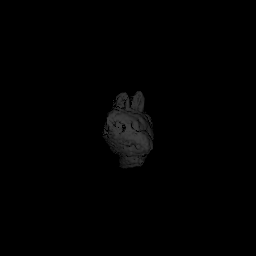

In [ ]:
%pdb on
while True:
    sdf_optimizer.optimization_step("a sculpture of a bunny")

In [ ]:
sdf_optimizer.config.camera.mapping_offset

In [ ]:
num_cameras = 16
camera_angle_list = sdf_optimizer.get_camera_angle_list(
    num_cameras=num_cameras,
    mapping_span=optim_config.camera.mapping_span,
    shuffle_order=optim_config.camera.shuffle_order,
    mapping_type=optim_config.camera.mapping_type,
)

output = widgets.Output()

def view_camera_angle(
    cam_view_idx, 
    resolution,
    prompt,
    num_iters,
    panning_range,
):
    cam_view_idx -= 1
    
    gen_img = sdf_optimizer.generate_image(
        camera_angle_list[cam_view_idx], 
    )
    
    image_initial_array = gen_img.detach().cpu().numpy() * 255
    
    display(Image.fromarray(image_initial_array.astype(np.uint8)))

menu = widgets.interactive(
    view_camera_angle,
    cam_view_idx=widgets.IntSlider(min=1, max=len(camera_angle_list), step=1, value=1),
    resolution=widgets.Dropdown(options=sdf_optimizer.sdf_grid_res_list),
    prompt="3D bunny rabbit mesh rendered with maya zbrush",
    num_iters=widgets.IntSlider(min=1, max=16, step=1, value=1),
    panning_range=widgets.IntSlider(min=1, max=len(camera_angle_list), step=1, value=1),
)

display(menu)

sculp_button = widgets.Button(description='Sculp!')

display(sculp_button, output)

def on_button_clicked(b):
    current_camera_view = menu.kwargs['cam_view_idx']
    current_prompt = menu.kwargs['prompt']
    num_iters = menu.kwargs['num_iters']
    panning_range = menu.kwargs['panning_range']
    
    for map_view_idx in range(panning_range):
        for iter_idx in range(num_iters):
            view_idx = int((current_camera_view + map_view_idx - panning_range/2) % num_cameras)
            
            with output:
                print("Optimizing...")
                print(f"VIEW - {view_idx} -- ITER - {iter_idx}")
                
            sdf_optimizer.optimize_view(
                current_prompt,
                camera_angle_list[view_idx],
            )
            
            display(menu)
        
            output.clear_output()
    

sculp_button.on_click(on_button_clicked)

